<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, Kiryll Bykov, Alexey Boldyrev ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>📈Crypto</font>](https://www.kaggle.com/competitions/11mar24hse-crypto/rules)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install -U kaggle  # upgrade kaggle package (to avoid a warning)

In [ ]:
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json           # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 11mar24hse-crypto # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download                     # download competition dataset as a zip file
!unzip -o *.zip                                   # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

- competition is now set to: 11mar24hse-crypto
Using competition: 11mar24hse-crypto
11mar24hse-crypto.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  11mar24hse-crypto.zip
  inflating: sampleSubmission.csv    
  inflating: tXY.csv                 Using competition: 11mar24hse-crypto
  teamId  teamName             submissionDate       score    
--------  -------------------  -------------------  -------  
11786133  Iskander Sergazin    2024-03-30 05:04:41  0.19040  
11764071  Kirill Kiosa         2024-03-31 14:20:19  0.18407  
11825272  Chislova Alena       2024-03-30 09:05:29  0.18390  
11830152  Shutov Alexey        2024-03-25 18:29:30  0.13909  
11834008  Kuzmishin Leonid     2024-03-30 20:05:44  0.13532  
11784492  F                    2024-03-31 15:42:59  0.13395  
11775405  Maxim Levin          2024-03-31 16:02:35  0.13257  
11764074  Kseniia Nechaeva     2024-03-24 10:30:39  0.13254  
11767807  Roman Kholinov       2024-03-16 20:06

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla T4 or Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15101 MiB, 0 MiB


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 1.68 s, sys: 219 ms, total: 1.89 s
Wall time: 1.94 s


Your training data are 7 descriptive features for past 500K observations. See helpful [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition).

In [ ]:
tXY = pd.read_csv('tXY.csv', index_col='id'); tXY

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
0,64,0.20,0.20,0.20,0.20,447,0.20
1,72,0.20,0.20,0.20,0.20,592,0.20
...,...,...,...,...,...,...,...
195216,63,0.09,0.09,0.09,0.09,306,0.09
195217,78,0.09,0.09,0.09,0.09,1023,0.09


Your task is to forecast the closing price for all future time steps (index IDs below).

In [ ]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

id,500000,500001,500002,500003,500004,500005,500006,500007,500008,500009,...,524421,524422,524423,524424,524425,524426,524427,524428,524429,524430
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer Start Here...</font></strong>


**TODO. Explain your preprocessing:**  i tried to use log of variables but this didn't give any boost

**TODO. Explain your modeling approach:** I tried to tune hyperparametres. In result of experiments best value for num_layers was 3, because if we would take 4 then we would need more epochs to train the model, as we get more deep network. Also I tried to increase all other parametres, but this caused Error with memory constraints or Time Limit.

Another thing I tried to use, is to implement biderectional LSTM, but this also caused Memorry error.

Also I tried to add CNN layers to highight some important patterns, but this also didn't give any boost

Also when I was doing this project I faced problem with Memory units of Google collab, so I couldn't proceed all my experiments, however I was using 3 google accounts

This is your baseline DNN model. Remember to [seed all your experiments](https://pytorch.org/docs/stable/notes/randomness.html#reproducibility) for reproducibility.

taX.shape=(K,Nx,p)=(50, 20000, 7); taY=(K,Ny)=(50, 24431)


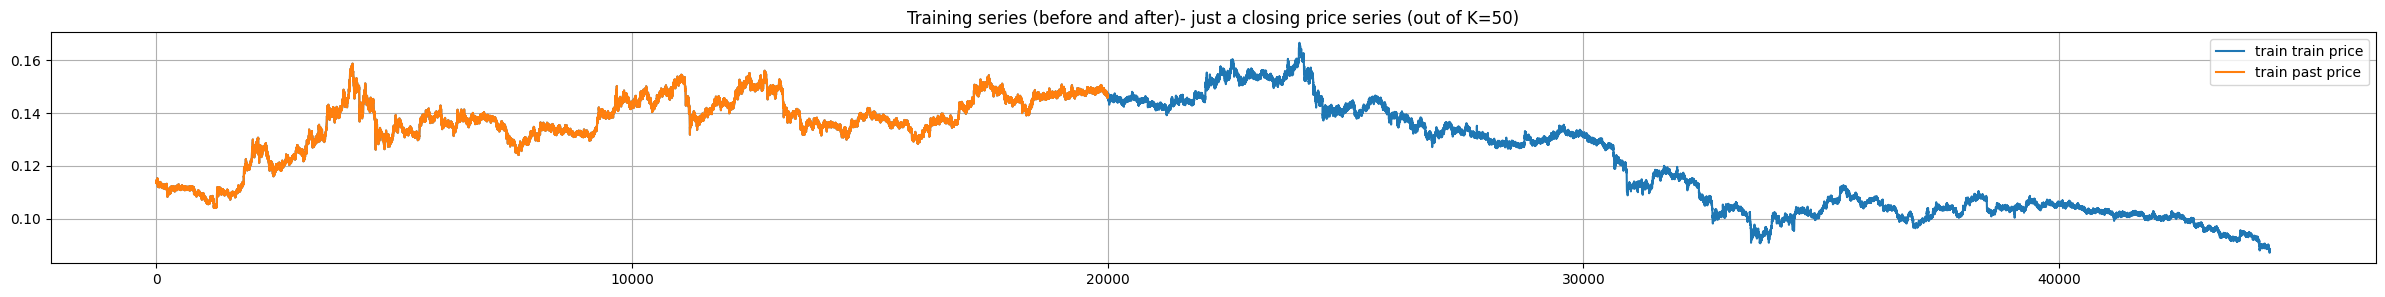

In [ ]:
K, (N, p), Nx, Ny = 50, tXY.shape, 20000, len(pY)  # samples, dataset dim, train set size, forecast set size
LtX, LtY = [], []
for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
  LtX.append(tXY.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY.append(tXY.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors

df = pd.DataFrame(np.r_[taX[0,:,4], taY[0,:]], columns=['train train price'])
ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
pd.DataFrame(taX[0,:,4], columns=['train past price']).plot(grid=True, ax=ax);

Build an LSTM model with two hidden layers. It splits $K$ samples into batches with 7D series $X_{N_x\times p}$ as input and 1D series $Y_{N_y\times 1}$ as output.


In [ ]:
taX = torch.Tensor(taX)
taY = torch.Tensor(taY)

In [ ]:
ds = TensorDataset(taX, taY)

In [ ]:
dl = DataLoader(ds, batch_size=32)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MyLSTMModel(nn.Module):
  def __init__(
      self,
      output_size,
      input_size,
      hidden_size=200,
      num_layers=3,
      bias=True,
      batch_first=True,
      dropout=0.2,

    ):
      super().__init__()

      self.lstm = nn.LSTM(input_size, hidden_size, dropout=dropout, num_layers=num_layers, batch_first=batch_first)
      self.dropout = nn.Dropout(dropout)
      self.linear = nn.LazyLinear(output_size)

  def forward(self, X):
      _, (last, _) = self.lstm(X)
      last = last[-1]
      last = self.dropout(last)
      last = self.linear(last)

      return last

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

m = MyLSTMModel(Ny, p)
m.to(device)

optim = torch.optim.Adam(m.parameters(), lr=0.001)
loss = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MyLSTMModel(
  (lstm): LSTM(7, 300, num_layers=4, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): LazyLinear(in_features=0, out_features=24431, bias=True)
)

In [ ]:
%%time
n_epoch = 40
m.train()

for e in range(n_epoch):
  losses = []
  print(f"Epoch: {e}")

  for i, (X, Y) in enumerate(dl):
    X = X.to(device)
    Y = Y.to(device)
    optim.zero_grad()

    pred = m(X)

    l = loss(pred, Y)
    l.backward()
    optim.step()

    losses.append(l.detach().item())

  print(f"Avg epoh loss: {sum(losses) / len(losses)}")

Epoch: 0


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.52 GiB. GPU 0 has a total capacity of 14.75 GiB of which 13.05 GiB is free. Process 43407 has 1.69 GiB memory in use. Of the allocated memory 1.56 GiB is allocated by PyTorch, and 10.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Avg epoh loss: 0.027151173911988735

The plot below: the model memorized the prices from recent history (plus some local noise). Still you can use these predictions to visually (i.e. qualitatively) determine whether predictions are meaningful (i.e. have price-like shape) or just noise.

In [ ]:
m.eval();  # To disable dropout at evaluation stage

In [ ]:
tX_recent = tXY.iloc[-Nx:,:]  # most recent history of the coin
print(f'tX_recent.shape=(Nx,p)={tX_recent.shape}')
with torch.no_grad():
  pY['Close'] = m(torch.Tensor(tX_recent.values[np.newaxis,...]).to(device)).cpu().numpy().flatten()
ax = pd.concat([tX_recent.Close, pY.Close]).plot(figsize=(30,3), title='Most recent input X and forecasted output Y');
tX_recent.Close.plot(ax=ax, grid=True);
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"]);

tX_recent.shape=(Nx,p)=(20000, 7)


KeyboardInterrupt: 

1. The model generates a baseline submission CSV file, see Colab folder (🗀 on the left).
1. You can download the generated CSV file and submit it to Kaggle.

In [ ]:
ToCSV(pY, 'Crypto-baseline2')

# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

# 💡**Starter Ideas**

1. Try different RNN architectures and hyperparameters
1. Try [correlation loss/metric](https://duckduckgo.com/?q=correlation+loss+in+tensorflow&ia=web) (or equivalent)
1. Try longer/shorter history. FYI: GPU may not fit all observations, but you could lower the precision or simplify DNN
1. Try forecasting returns (differences or log differences at different lags) instead of actual values. Returns might appear "more" stationary (You'll need to compute forecasted prices from forecasted returns later)
1. Try new features: differences, fractions, powers of existing features, lagged features or lagged differences,..
1. Try a different time scale. Eg. forecasting every $k$ steps and then imputing interim values
1. Try technique in HOML pp.509-510
1. Try (programmatically) assigning higher/lower weights to history or historical events (such as extreme events)
1. Check [Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting/code) competition for more suitable ideas.
1. Try further smoothing/averaging and forecasting values at sparser intervals
1. Try forecasting just the future trend